### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy import create_engine

import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import altair
import folium

import warnings
warnings.filterwarnings('ignore')

### Importing 2020 Data using function


In [2]:

# Source: http://web.mta.info/developers/turnstile.html
def get_data_parse_dt(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs)

# april - june 2021
week_nums = [200404,200411, 200418, 200425,
             200502, 200509, 200516, 200523, 200530,
             200606, 200613, 200620, 200627] 
turnstiles_df2000 = get_data_parse_dt(week_nums)
turnstiles_df2000.head()


,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,2020-03-28 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/28/2020,00:00:00,REGULAR,7412829,2516511
1,2020-03-28 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/28/2020,04:00:00,REGULAR,7412831,2516512
2,2020-03-28 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/28/2020,08:00:00,REGULAR,7412837,2516526
3,2020-03-28 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/28/2020,12:00:00,REGULAR,7412849,2516538
4,2020-03-28 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/28/2020,16:00:00,REGULAR,7412880,2516555


### Using SQLENGINE to load 2021 Turnstile Data

In [154]:

# Create connection to mta_data.db
# Source: http://web.mta.info/developers/turnstile.html
engine = create_engine("sqlite:///mta_data.db")
engine.table_names()
## ['mta_data'] 

['mta_data']

In [155]:
# Read sqlite query results into a pandas DataFrame

con = sqlite3.connect("mta_data.db")
df_MTA = pd.read_sql_query("SELECT * from mta_data", con)

# Verify that result of SQL query is stored in the dataframe
print(df_MTA.head())

# Close connection
con.close()

    C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  09/11/2021  00:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  09/11/2021  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  09/11/2021  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  09/11/2021  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  09/11/2021  16:00:00   

      DESC  ENTRIES    EXITS  
0  REGULAR  7633126  2611933  
1  REGULAR  7633141  2611934  
2  REGULAR  7633152  2611953  
3  REGULAR  7633203  2611997  
4  REGULAR  7633308  2612026  


In [156]:
df_MTA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954394 entries, 0 to 7954393
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 667.6+ MB


In [157]:
# check for null values
df_MTA.isna().sum()
turnstiles_df2000.isna().sum()

DATE_TIME                                                               0
C/A                                                                     0
UNIT                                                                    0
SCP                                                                     0
STATION                                                                 0
LINENAME                                                                0
DIVISION                                                                0
DATE                                                                    0
TIME                                                                    0
DESC                                                                    0
ENTRIES                                                                 0
EXITS                                                                   0
dtype: int64

In [158]:
# create a copy of data for manipulation
df_mta2 = df_MTA.copy()
df_mta2old = turnstiles_df2000.copy()

In [159]:
# Create DATETIME column by combining DATE and TIME
df_mta2['DATETIME'] = pd.to_datetime(df_mta2['DATE'].str.cat(df_mta2['TIME'],sep=" "), format="%m/%d/%Y %H:%M:%S")
df_mta2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954394 entries, 0 to 7954393
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   C/A       object        
 1   UNIT      object        
 2   SCP       object        
 3   STATION   object        
 4   LINENAME  object        
 5   DIVISION  object        
 6   DATE      object        
 7   TIME      object        
 8   DESC      object        
 9   ENTRIES   int64         
 10  EXITS     int64         
 11  DATETIME  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 728.2+ MB


In [160]:
# Convert DATE and TIME to datetime format
df_mta2['DATE'] = pd.to_datetime(df_mta2['DATE'])
df_mta2['TIME'] = pd.to_datetime(df_mta2['TIME'])
df_mta2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954394 entries, 0 to 7954393
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   C/A       object        
 1   UNIT      object        
 2   SCP       object        
 3   STATION   object        
 4   LINENAME  object        
 5   DIVISION  object        
 6   DATE      datetime64[ns]
 7   TIME      datetime64[ns]
 8   DESC      object        
 9   ENTRIES   int64         
 10  EXITS     int64         
 11  DATETIME  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(7)
memory usage: 728.2+ MB


In [161]:
# subset MTA data to include data only from  03-27-2021 to 07-01-2021
start_date = '2021-03-27'
end_date = '2021-07-01'
mta_mask = (df_mta2['DATE'] > start_date) & (df_mta2['DATE'] <= end_date)
  
turnstiles_df = df_mta2.loc[mta_mask]
turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2870155 entries, 2304188 to 5234566
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   C/A       object        
 1   UNIT      object        
 2   SCP       object        
 3   STATION   object        
 4   LINENAME  object        
 5   DIVISION  object        
 6   DATE      datetime64[ns]
 7   TIME      datetime64[ns]
 8   DESC      object        
 9   ENTRIES   int64         
 10  EXITS     int64         
 11  DATETIME  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(7)
memory usage: 284.7+ MB


In [162]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATETIME" is unique
(turnstiles_df
    .groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"])
    .ENTRIES.count()
    .reset_index()
    .sort_values("ENTRIES", ascending=False)).head(10)

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
1195277,N329,R201,00-03-02,WOODHAVEN BLVD,2021-05-08 01:00:00,2
243715,B024,R211,00-05-00,KINGS HWY,2021-05-03 16:00:00,2
1195278,N329,R201,00-03-02,WOODHAVEN BLVD,2021-05-08 05:00:00,2
1195279,N329,R201,00-03-02,WOODHAVEN BLVD,2021-05-08 09:00:00,2
1241099,N336,R158,00-00-05,KEW GARDENS,2021-06-20 18:30:00,2
243724,B024,R211,00-05-00,KINGS HWY,2021-05-05 04:00:00,2
243723,B024,R211,00-05-00,KINGS HWY,2021-05-05 00:00:00,2
243722,B024,R211,00-05-00,KINGS HWY,2021-05-04 20:00:00,2
1054186,N213,R154,00-00-00,TREMONT AV,2021-06-23 05:00:00,2
243721,B024,R211,00-05-00,KINGS HWY,2021-05-04 16:00:00,2


In [163]:
# KINGS HWY has 2 entries for the same time.
# Isolate a single record to see what makes it a duplicate
mask = ((turnstiles_df["C/A"] == "B024") & 
(turnstiles_df["UNIT"] == "R211") & 
(turnstiles_df["SCP"] == "00-05-00") & 
(turnstiles_df["STATION"] == "KINGS HWY") & 
(turnstiles_df["DATETIME"].dt.date == dt.datetime(2021,5,1).date()))

turnstiles_df[mask]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
3996697,B024,R211,00-05-00,KINGS HWY,BQ,BMT,2021-05-01,2021-10-13 00:00:00,REGULAR,262152,0,2021-05-01 00:00:00
3996698,B024,R211,00-05-00,KINGS HWY,BQ,BMT,2021-05-01,2021-10-13 00:00:00,RECOVR AUD,11,0,2021-05-01 00:00:00
3996699,B024,R211,00-05-00,KINGS HWY,BQ,BMT,2021-05-01,2021-10-13 04:00:00,REGULAR,262152,0,2021-05-01 04:00:00
3996700,B024,R211,00-05-00,KINGS HWY,BQ,BMT,2021-05-01,2021-10-13 08:00:00,REGULAR,262152,0,2021-05-01 08:00:00
3996701,B024,R211,00-05-00,KINGS HWY,BQ,BMT,2021-05-01,2021-10-13 08:00:00,RECOVR AUD,12,0,2021-05-01 08:00:00
3996702,B024,R211,00-05-00,KINGS HWY,BQ,BMT,2021-05-01,2021-10-13 12:00:00,REGULAR,262152,0,2021-05-01 12:00:00
3996703,B024,R211,00-05-00,KINGS HWY,BQ,BMT,2021-05-01,2021-10-13 12:00:00,RECOVR AUD,12,0,2021-05-01 12:00:00
3996704,B024,R211,00-05-00,KINGS HWY,BQ,BMT,2021-05-01,2021-10-13 16:00:00,REGULAR,262152,0,2021-05-01 16:00:00
3996705,B024,R211,00-05-00,KINGS HWY,BQ,BMT,2021-05-01,2021-10-13 16:00:00,RECOVR AUD,13,0,2021-05-01 16:00:00
3996706,B024,R211,00-05-00,KINGS HWY,BQ,BMT,2021-05-01,2021-10-13 20:00:00,REGULAR,262152,0,2021-05-01 20:00:00


In [164]:
# The difference is between DESC = Regular and DESC = RECOVR AUD
# As there are duplicate values for certain dates due to DESC column, count the duplicates

turnstiles_df.DESC.value_counts()

REGULAR       2859312
RECOVR AUD      10843
Name: DESC, dtype: int64

In [165]:
# Get rid of the duplicate data
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATETIME"], 
                          inplace=True, ascending=False)

turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
2514011,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-07-01,2021-10-13 21:00:00,REGULAR,5554,585,2021-07-01 21:00:00
2514010,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-07-01,2021-10-13 17:00:00,REGULAR,5554,585,2021-07-01 17:00:00
2514009,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-07-01,2021-10-13 13:00:00,REGULAR,5554,584,2021-07-01 13:00:00
2514008,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-07-01,2021-10-13 09:00:00,REGULAR,5554,584,2021-07-01 09:00:00
2514007,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-07-01,2021-10-13 05:00:00,REGULAR,5554,584,2021-07-01 05:00:00


In [166]:
# check again for duplicate entries
(turnstiles_df
    .groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"])
    .ENTRIES.count()
    .reset_index()
    .sort_values("ENTRIES", ascending=False)).head(10)

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-03-28 00:00:00,1
1913404,R138,R293,00-05-00,34 ST-PENN STA,2021-04-09 14:00:00,1
1913396,R138,R293,00-05-00,34 ST-PENN STA,2021-04-08 06:00:00,1
1913397,R138,R293,00-05-00,34 ST-PENN STA,2021-04-08 10:00:00,1
1913398,R138,R293,00-05-00,34 ST-PENN STA,2021-04-08 14:00:00,1
1913399,R138,R293,00-05-00,34 ST-PENN STA,2021-04-08 18:00:00,1
1913400,R138,R293,00-05-00,34 ST-PENN STA,2021-04-08 22:00:00,1
1913401,R138,R293,00-05-00,34 ST-PENN STA,2021-04-09 02:00:00,1
1913402,R138,R293,00-05-00,34 ST-PENN STA,2021-04-09 06:00:00,1
1913403,R138,R293,00-05-00,34 ST-PENN STA,2021-04-09 10:00:00,1


In [167]:
# Only single entries exist per combination.
# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

In [168]:
# inspect a single turnstile at date 2021,5,1
turnstiles_df[(turnstiles_df["C/A"] == "A002") & 
(turnstiles_df["UNIT"] == "R051") & 
(turnstiles_df["SCP"] == "02-00-00") & 
(turnstiles_df["STATION"] == "59 ST") &
(turnstiles_df["DATETIME"].dt.date == dt.datetime(2021,5,1).date())]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,DATETIME
3978997,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-01,2021-10-13 20:00:00,7564974,2021-05-01 20:00:00
3978996,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-01,2021-10-13 16:00:00,7564813,2021-05-01 16:00:00
3978995,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-01,2021-10-13 12:00:00,7564691,2021-05-01 12:00:00
3978994,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-01,2021-10-13 08:00:00,7564642,2021-05-01 08:00:00
3978993,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-01,2021-10-13 04:00:00,7564621,2021-05-01 04:00:00
3978992,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-01,2021-10-13 00:00:00,7564613,2021-05-01 00:00:00


In [169]:
# grab top most record which represents final reading for the day
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [170]:
turnstiles_daily.head(5)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-03-28,7550675
1,A002,R051,02-00-00,59 ST,2021-03-29,7551178
2,A002,R051,02-00-00,59 ST,2021-03-30,7551731
3,A002,R051,02-00-00,59 ST,2021-03-31,7552051
4,A002,R051,02-00-00,59 ST,2021-04-01,7552051


In [171]:
# create additional columns to compute entries by day
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

In [172]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,2021-03-28,7550675,NaT,NaN
1,A002,R051,02-00-00,59 ST,2021-03-29,7551178,2021-03-28,7550675.0
2,A002,R051,02-00-00,59 ST,2021-03-30,7551731,2021-03-29,7551178.0
3,A002,R051,02-00-00,59 ST,2021-03-31,7552051,2021-03-30,7551731.0
4,A002,R051,02-00-00,59 ST,2021-04-01,7552051,2021-03-31,7552051.0


In [173]:
# Drop the rows for the earliest date in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [174]:
# Check if all ENTRIES > PREV_ENTRIES to see if all counters are working the same (cumulative)
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
3745,A011,R080,01-03-00,57 ST-7 AV,2021-03-29,885614981,2021-03-28,885615115.0
3746,A011,R080,01-03-00,57 ST-7 AV,2021-03-30,885614771,2021-03-29,885614981.0
3747,A011,R080,01-03-00,57 ST-7 AV,2021-03-31,885614541,2021-03-30,885614771.0
3748,A011,R080,01-03-00,57 ST-7 AV,2021-04-01,885614329,2021-03-31,885614541.0
3749,A011,R080,01-03-00,57 ST-7 AV,2021-04-02,885614137,2021-04-01,885614329.0


In [175]:
# check if counter is reversed
mask = ((turnstiles_df["C/A"] == "A011") & 
(turnstiles_df["UNIT"] == "R080") & 
(turnstiles_df["SCP"] == "01-03-00") & 
(turnstiles_df["STATION"] == "57 ST-7 AV") &
(turnstiles_df["DATETIME"].dt.date == dt.datetime(2021, 3, 28).date()))
turnstiles_df[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,DATETIME
5027204,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,2021-03-28,2021-10-13 20:00:00,885615115,2021-03-28 20:00:00
5027203,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,2021-03-28,2021-10-13 16:00:00,885615145,2021-03-28 16:00:00
5027202,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,2021-03-28,2021-10-13 12:00:00,885615170,2021-03-28 12:00:00
5027201,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,2021-03-28,2021-10-13 08:00:00,885615178,2021-03-28 08:00:00
5027200,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,2021-03-28,2021-10-13 04:00:00,885615184,2021-03-28 04:00:00


In [176]:
# Let's see how many stations have this problem

(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A    UNIT  SCP       STATION        
A011   R080  01-03-00  57 ST-7 AV         95
             01-03-03  57 ST-7 AV          1
             01-03-04  57 ST-7 AV          1
A013   R081  01-06-01  49 ST               1
A015   R081  00-00-02  49 ST               1
                                          ..
R617   R058  00-00-02  BERGEN ST           1
R622   R123  00-00-00  FRANKLIN AV        95
R730   R431  00-00-04  EASTCHSTER/DYRE    94
S101   R070  00-00-04  ST. GEORGE          1
TRAM2  R469  00-05-00  RIT-ROOSEVELT       1
Length: 221, dtype: int64

In [177]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 500k, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits

turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=500000)

In [178]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,2021-03-29,7551178,2021-03-28,7550675.0,503.0
2,A002,R051,02-00-00,59 ST,2021-03-30,7551731,2021-03-29,7551178.0,553.0
3,A002,R051,02-00-00,59 ST,2021-03-31,7552051,2021-03-30,7551731.0,320.0
4,A002,R051,02-00-00,59 ST,2021-04-01,7552051,2021-03-31,7552051.0,0.0
5,A002,R051,02-00-00,59 ST,2021-04-02,7552051,2021-04-01,7552051.0,0.0


In [179]:
#For each ControlArea/UNIT/STATION combo, for each day, sum the counts from each turnstile 
ca_unit_station_daily = turnstiles_daily.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
ca_unit_station_daily.head()

,C/A,UNIT,STATION,DATE,DAILY_ENTRIES
0,A002,R051,59 ST,2021-03-29,4244.0
1,A002,R051,59 ST,2021-03-30,4808.0
2,A002,R051,59 ST,2021-03-31,4589.0
3,A002,R051,59 ST,2021-04-01,4495.0
4,A002,R051,59 ST,2021-04-02,4114.0


In [209]:
# Get daily total for each Station
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily.head()


KeyError: "Columns not found: 'DAILY_ENTRIES'"

In [210]:
# some DAILY_ENTRIES seem unexpectedly high (6 times the mean), so it might be useful to investigate later 
station_daily[station_daily['DAILY_ENTRIES']>station_daily['DAILY_ENTRIES'] \
            .mean()*6] \
            .sort_values('DAILY_ENTRIES',ascending=False)

,STATION,DATE,DAILY_ENTRIES
29904,PATH NEW WTC,2021-05-05,665697.0
0,1 AV,2021-03-29,633578.0
30075,PAVONIA/NEWPORT,2021-04-16,627318.0
24925,KINGS HWY,2021-05-07,537046.0
377,104 ST,2021-06-29,492275.0
...,...,...,...
22175,GRD CNTRL-42 ST,2021-05-12,30868.0
10475,86 ST,2021-04-27,30856.0
5878,34 ST-PENN STA,2021-06-20,30856.0
5627,34 ST-HERALD SQ,2021-04-20,30795.0


In [182]:
# grab top most record which represents final reading for the day
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-03-28,7550675
1,A002,R051,02-00-00,59 ST,2021-03-29,7551178
2,A002,R051,02-00-00,59 ST,2021-03-30,7551731
3,A002,R051,02-00-00,59 ST,2021-03-31,7552051
4,A002,R051,02-00-00,59 ST,2021-04-01,7552051


### Repeat process for 2020 data

In [36]:

#create DATETIME column
df_mta2old['DATETIME'] = pd.to_datetime(df_mta2old['DATE'].str.cat(df_mta2old['TIME'],sep=" "), format="%m/%d/%Y %H:%M:%S")

In [37]:
# Convert DATE and TIME to datetime format
df_mta2old['DATE'] = pd.to_datetime(df_mta2old['DATE'])
df_mta2old['TIME'] = pd.to_datetime(df_mta2old['TIME'])
df_mta2old.info()

#Drop duplicates 
df_mta2old.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATETIME"], 
                          inplace=True, ascending=False)
df_mta2old.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)

# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
df_mta2old = df_mta2old.drop(["EXITS", "DESC"], axis=1, errors="ignore")

# grab top most record which represents final reading for the day
turnstiles_dailyold = (df_mta2old
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

# create additional columns to compute entries by day
turnstiles_dailyold[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_dailyold
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))


# Drop the rows for the earliest date in the df
turnstiles_dailyold.dropna(subset=["PREV_DATE"], axis=0, inplace=True)


# If counter is > 500k, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits

turnstiles_dailyold["DAILY_ENTRIES"] = turnstiles_dailyold.apply(get_daily_counts, axis=1, max_counter=500000)


#For each ControlArea/UNIT/STATION combo, for each day, sum the counts from each turnstile 
ca_unit_station_dailyold = turnstiles_dailyold.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
ca_unit_station_dailyold.head()


# Get daily total for each Station
station_dailyold = turnstiles_dailyold.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_dailyold.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2689135 entries, 0 to 206670
Data columns (total 13 columns):
 #   Column                                                                Dtype         
---  ------                                                                -----         
 0   DATE_TIME                                                             datetime64[ns]
 1   C/A                                                                   object        
 2   UNIT                                                                  object        
 3   SCP                                                                   object        
 4   STATION                                                               object        
 5   LINENAME                                                              object        
 6   DIVISION                                                              object        
 7   DATE                                                                  dat

,STATION,DATE,DAILY_ENTRIES
0,1 AV,2020-03-29,513.0
1,1 AV,2020-03-30,1648.0
2,1 AV,2020-03-31,1650.0
3,1 AV,2020-04-01,1668.0
4,1 AV,2020-04-02,1498.0


### Comparing Ridership for 10 stations

In [108]:
# subset data for comparison
stat20 = station_totalsold.sort_values('STATION').head(10)
stat21 = station_totals.sort_values('STATION').head(10)
# add a year column to the data
stat20['YEAR'] = 2020
stat21['YEAR'] = 2021
statlist1 = [stat20, stat21]

stat_combo = pd.concat(statlist1)

In [110]:
# plotting the comparison

import altair as alt
source = stat_combo

alt.Chart(source).mark_bar().encode(
    #x='YEAR:O',
    x=alt.X('YEAR:O', title='Year'),
    #y='DAILY_ENTRIES:Q',
    y=alt.Y('DAILY_ENTRIES:Q', title='Passengers'),
    color='YEAR:N',
    column='STATION'
)


alt.Chart(...)

## Top 10 Busiest Stations 2021

In [149]:
# further aggregate the station_daily data to get totals for each station within the time series
station_totals = station_daily.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()



station_totalsold = station_dailyold.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()



In [312]:
station_totals.sort_values('DAILY_ENTRIES',ascending = False).head(10)

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,4186859.0
1,86 ST,3451640.0
2,PATH NEW WTC,3304567.0
3,34 ST-HERALD SQ,3070981.0
4,125 ST,2864695.0
5,GRD CNTRL-42 ST,2593548.0
6,KINGS HWY,2474248.0
7,42 ST-PORT AUTH,2470366.0
8,23 ST,2455883.0
9,14 ST-UNION SQ,2399143.0


In [150]:
# plot busiest Stations
source = station_totals.sort_values('DAILY_ENTRIES',ascending = False).head(10)

alt.Chart(source, title="Top 10 Busiest Stations").mark_bar().encode(
    #x='NAME:O',
    x=alt.X('STATION:O', title='Station Name'),
    #y="DAILY_ENTRIES:Q",
    y=alt.Y('DAILY_ENTRIES:Q', title='Total Entries'),
    # The highlight will be set on the result of a conditional statement
    color=alt.condition(
        alt.datum.STATION == '34 ST-PENN STA',  # If UPPER_NAME is 88 ST this test returns True,
        
        alt.value('orange'),     # which sets the bar orange.
        alt.value('steelblue')   # And if it's not true it sets the bar steelblue.
    )
).properties(width=600)

alt.Chart(...)

In [148]:
#subset the data to top 10 stations only

top10_stations_2020 = station_totals.head(10)
top10_stations_2021 = station_totalsold.head(10)

#add a year column to the data
top10_stations_2020['YEAR'] = 2020
top10_stations_2021['YEAR'] = 2021

# concat the 2 dataframes
statlist2 = [top10_stations_2020, top10_stations_2021]
top10combo = pd.concat(statlist2)

In [115]:

# write out station_totals data for visualizations
station_totals.to_csv('data/station_totals.csv')
station_totalsold.to_csv('data/station_totalsold.csv')

In [188]:
turnstiles_daily[turnstiles_daily['STATION']== "34 ST-PENN STA"]

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
126327,N067,R012,00-00-00,34 ST-PENN STA,2021-03-28,238944
126328,N067,R012,00-00-00,34 ST-PENN STA,2021-03-29,239151
126329,N067,R012,00-00-00,34 ST-PENN STA,2021-03-30,239380
126330,N067,R012,00-00-00,34 ST-PENN STA,2021-03-31,239629
126331,N067,R012,00-00-00,34 ST-PENN STA,2021-04-01,239858
...,...,...,...,...,...,...
322003,R142,R293,01-06-01,34 ST-PENN STA,2021-06-27,68080800
322004,R142,R293,01-06-01,34 ST-PENN STA,2021-06-28,68081006
322005,R142,R293,01-06-01,34 ST-PENN STA,2021-06-29,68081172
322006,R142,R293,01-06-01,34 ST-PENN STA,2021-06-30,68081337


In [187]:
# Analyze traffic at single station
#daily_turnstiles = ca_unit_station_daily.sort_values('DAILY_ENTRIES',ascending=False)

single_turnstile = turnstiles_daily[(turnstiles_daily["C/A"] == "N067") & 
(turnstiles_daily["UNIT"] == "R012") & 
(turnstiles_daily["SCP"] == "00-00-00") & 
(turnstiles_daily["STATION"] == "34 ST-PENN STA")]

single_turnstile2021 = turnstiles_daily[(turnstiles_daily["C/A"] == "N067") & 
(turnstiles_daily["UNIT"] == "R012") & 
(turnstiles_daily["SCP"] == "00-00-00") & 
(turnstiles_daily["STATION"] == "34 ST-PENN STA")]

single_turnstile2020 = turnstiles_dailyold[(turnstiles_dailyold["C/A"] == "N067") & 
(turnstiles_dailyold["UNIT"] == "R012") & 
(turnstiles_dailyold["SCP"] == "00-00-00") & 
(turnstiles_dailyold["STATION"] == "34 ST-PENN STA")]

single_turnstile




,C/A,UNIT,SCP,STATION,DATE,ENTRIES
126327,N067,R012,00-00-00,34 ST-PENN STA,2021-03-28,238944
126328,N067,R012,00-00-00,34 ST-PENN STA,2021-03-29,239151
126329,N067,R012,00-00-00,34 ST-PENN STA,2021-03-30,239380
126330,N067,R012,00-00-00,34 ST-PENN STA,2021-03-31,239629
126331,N067,R012,00-00-00,34 ST-PENN STA,2021-04-01,239858
...,...,...,...,...,...,...
126418,N067,R012,00-00-00,34 ST-PENN STA,2021-06-27,261024
126419,N067,R012,00-00-00,34 ST-PENN STA,2021-06-28,261373
126420,N067,R012,00-00-00,34 ST-PENN STA,2021-06-29,261715
126421,N067,R012,00-00-00,34 ST-PENN STA,2021-06-30,262079


In [252]:
#isolate records for a single station for 2020 and 2021
station_daily_34Pennold = station_dailyold[station_dailyold['STATION'] == '34 ST-PENN STA']
station_daily_34Penn = station_daily[station_daily['STATION'] == '34 ST-PENN STA']


# add a year column to the data
station_daily_34Pennold['YEAR'] = 2020
station_daily_34Penn['YEAR'] = 2021
stat_daily_list1 = [station_daily_34Pennold, station_daily_34Penn]

single_station_combo = pd.concat(stat_daily_list1)


single_station_combo['month'] = single_station_combo['DATE'].dt.month
single_station_combo['day'] = single_station_combo['DATE'].dt.day

#create dummy year for charting
single_station_combo['dummy']= '2000'
pd.to_datetime(single_station_combo.dummy, format='%Y')

cols=["dummy","month","day"]
single_station_combo['dummydate'] = single_station_combo[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")



single_station_combo.head()

,STATION,DATE,DAILY_ENTRIES,YEAR,month,day,dummy,dummydate
5490,34 ST-PENN STA,2020-03-29,3967.0,2020,3,29,2000,2000-3-29
5491,34 ST-PENN STA,2020-03-30,9255.0,2020,3,30,2000,2000-3-30
5492,34 ST-PENN STA,2020-03-31,9135.0,2020,3,31,2000,2000-3-31
5493,34 ST-PENN STA,2020-04-01,8583.0,2020,4,1,2000,2000-4-1
5494,34 ST-PENN STA,2020-04-02,8184.0,2020,4,2,2000,2000-4-2


In [215]:
import altair as alt
import pandas as pd

source = pd.DataFrame({
    'a': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'],
    'b': [28, 55, 43, 91, 81, 53, 19, 87, 52]
})

alt.Chart(source).mark_bar().encode(
    x = 'b',
    y=alt.Y('a', axis=alt.Axis(tickSize=0))
)


y=alt.Y('person:Q', axis=alt.Axis(values=[1,2])),

alt.Chart(...)

In [253]:
chartix = single_station_combo.copy()

chartix["lbl"] = chartix["month"].astype('str') +  '-' +  chartix["day"].astype('str')


In [309]:
single_station_combo.sort_values('month')

,STATION,DATE,DAILY_ENTRIES,YEAR,month,day,dummy,dummydate
5490,34 ST-PENN STA,2020-03-29,3967.0,2020,3,29,2000,2000-3-29
5796,34 ST-PENN STA,2021-03-30,36287.0,2021,3,30,2000,2000-3-30
5795,34 ST-PENN STA,2021-03-29,33197.0,2021,3,29,2000,2000-3-29
5797,34 ST-PENN STA,2021-03-31,35197.0,2021,3,31,2000,2000-3-31
5492,34 ST-PENN STA,2020-03-31,9135.0,2020,3,31,2000,2000-3-31
...,...,...,...,...,...,...,...,...
5578,34 ST-PENN STA,2020-06-25,21009.0,2020,6,25,2000,2000-6-25
5579,34 ST-PENN STA,2020-06-26,19418.0,2020,6,26,2000,2000-6-26
5888,34 ST-PENN STA,2021-06-30,48346.0,2021,6,30,2000,2000-6-30
5557,34 ST-PENN STA,2020-06-04,12845.0,2020,6,4,2000,2000-6-4


In [311]:

source = single_station_combo.sort_values('month').head(60)


alt.Chart(source).mark_line().encode(
    #alt.X('dummydate:O'),
    alt.X('dummydate:O', title='Days'),
    alt.Y('DAILY_ENTRIES:Q', title='Passengers'),
    #alt.Y('DAILY_ENTRIES:Q', axis=alt.Axis(format='%')),
    color='YEAR:N'
)


alt.Chart(...)

In [259]:
station_daily_34Pennold.columns

Index(['STATION', 'DATE', 'DAILY_ENTRIES', 'YEAR'], dtype='object')

(array([18718., 18732., 18748., 18762., 18779., 18793., 18809.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

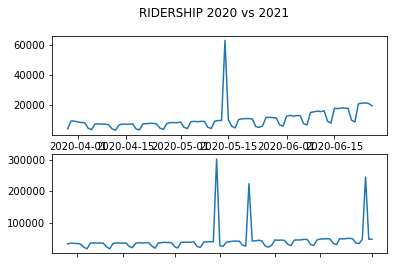

In [271]:
sd20 = station_dailyold[station_dailyold['STATION'] == '34 ST-PENN STA']
sd21 = station_daily[station_daily['STATION'] == '34 ST-PENN STA']

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)

fig.suptitle('RIDERSHIP 2020 vs 2021')
axs[0].plot(sd20.DATE, sd20.DAILY_ENTRIES)
axs[1].plot(sd21.DATE, sd21.DAILY_ENTRIES)


In [ ]:
figure, axes = plt.subplots(1, 2)
df1.plot(ax=axes[0])
df2.plot(ax=axes[1])

Text(0.5, 1.0, 'Daily Entries N067/R012/00-00-00/34 ST-PENN Station')

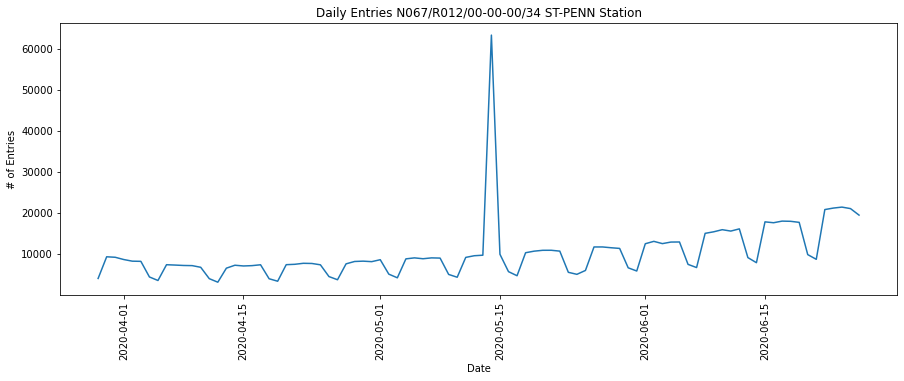

In [197]:
# plot 2020 
plt.figure(figsize=(15,5))
plt.plot(station_daily_34Pennold['DATE'], station_daily_34Pennold['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.title('Daily Entries N067/R012/00-00-00/34 ST-PENN Station')


Text(0.5, 1.0, 'Daily Entries N067/R012/00-00-00/34 ST-PENN Station')

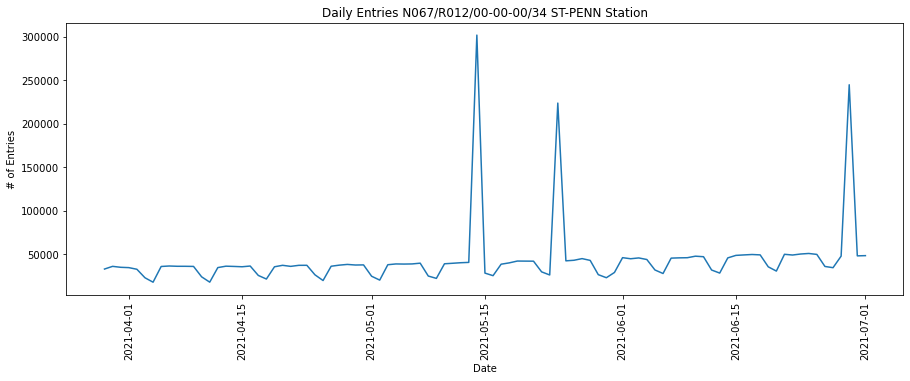

In [272]:
# plot 2021 
plt.figure(figsize=(15,5))
plt.plot(station_daily_34Penn['DATE'], station_daily_34Penn['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.title('Daily Entries N067/R012/00-00-00/34 ST-PENN Station')


In [194]:
#station_daily_34Penn[(station_daily_34Penn['DAILY_ENTRIES']==station_daily_34Penn['DAILY_ENTRIES'].max())]
#Spikes in ridership?
station_daily_34Penn.nlargest(3, 'DAILY_ENTRIES')


,STATION,DATE,DAILY_ENTRIES
5841,34 ST-PENN STA,2021-05-14,302049.0
5887,34 ST-PENN STA,2021-06-29,244985.0
5851,34 ST-PENN STA,2021-05-24,223926.0


In [274]:
station_daily_34Penn['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily_34Penn['DATE']).dt.dayofweek
station_daily_34Penn['WEEK_OF_YEAR'] = pd.to_datetime(station_daily_34Penn['DATE']).dt.week
station_daily_34Penn.head()

,STATION,DATE,DAILY_ENTRIES,DAY_OF_WEEK_NUM,WEEK_OF_YEAR
5795,34 ST-PENN STA,2021-03-29,33197.0,0,13
5796,34 ST-PENN STA,2021-03-30,36287.0,1,13
5797,34 ST-PENN STA,2021-03-31,35197.0,2,13
5798,34 ST-PENN STA,2021-04-01,34822.0,3,13
5799,34 ST-PENN STA,2021-04-02,32944.0,4,13


Text(0.5, 1.0, 'Ridership per day for 34th St. Penn Station')

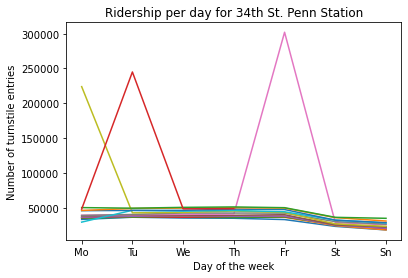

In [275]:
for i, group in station_daily_34Penn.groupby('WEEK_OF_YEAR'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_ENTRIES'])
    
plt.xlabel('Day of the week')
plt.ylabel('Number of turnstile entries')
plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn'])
plt.title('Ridership per day for 34th St. Penn Station')

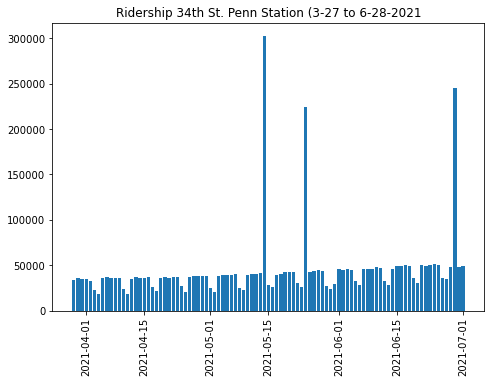

In [277]:
# plot daily activity for 
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
dates = station_daily_34Penn['DATE']
entries = station_daily_34Penn['DAILY_ENTRIES']
plt.title('Ridership 34th St. Penn Station (3-27 to 6-28-2021')
plt.xticks(rotation=90)
ax.bar(dates,entries)
plt.show()

Text(0.5, 1.0, 'Daily Entries for Turnstile N071 R013 00-00-01 @ 34 ST-PENN STA')

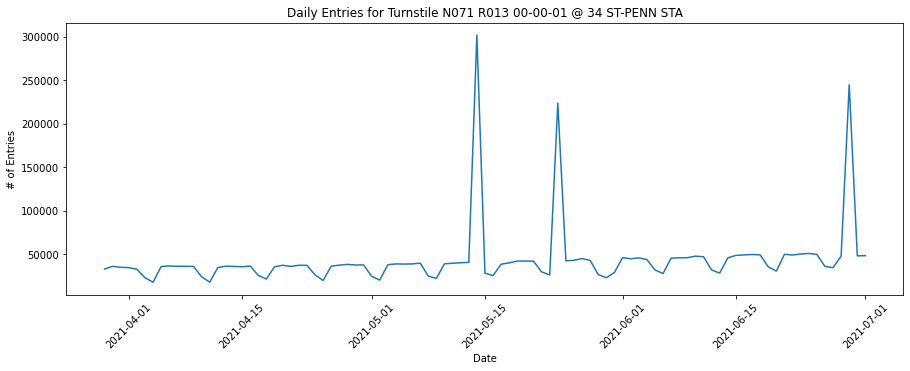

In [1419]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(station_daily_34Penn['DATE'], station_daily_34Penn['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for Turnstile N071 R013 00-00-01 @ 34 ST-PENN STA')


In [1246]:
import altair as alt
import numpy as np
import pandas as pd

source = station_daily_34Penn

#plt.plot(single_turnstile['DATE'], single_turnstile['DAILY_ENTRIES'])

alt.Chart(source).mark_line().encode(
    x='DATE',
    x=alt.X('STATION:O', title='Station Name'),
    y='DAILY_ENTRIES'
)

alt.Chart(...)

## get Station Lat and Long for plotting

In [278]:
# import station location data
df_stations = pd.read_csv(r'data/MTA_locations.csv')

df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URL       473 non-null    object
 1   OBJECTID  473 non-null    int64 
 2   NAME      473 non-null    object
 3   the_geom  473 non-null    object
 4   LINE      473 non-null    object
 5   NOTES     473 non-null    object
dtypes: int64(1), object(5)
memory usage: 22.3+ KB


In [279]:
def getLong(pointData1):
    split1 = pointData1[7:]
    split2 = split1.split(' ')
    longitude = split2[0]
    #print(longitude)
    return longitude

def getLat(pointData2):
    split3 = pointData2[7:].split(' ')
    latitude = split3[1].replace(')','')
    #print(latitude)
    return latitude

#getLong('POINT (-73.89488591154061 40.66471445143568)')
#getLat('POINT (-73.89488591154061 40.66471445143568)')

''' 

#Use this for testing a small sample
sample = df_stations.copy().head(10)

sample['Latitude'] = sample.the_geom.apply(getLat)
sample['Longitude'] = sample.the_geom.apply(getLong)
sample[['Latitude', 'Longitude']] = sample[['Latitude', 'Longitude']].apply(pd.to_numeric)
sample.head(10)

'''



" \n\n#Use this for testing a small sample\nsample = df_stations.copy().head(10)\n\nsample['Latitude'] = sample.the_geom.apply(getLat)\nsample['Longitude'] = sample.the_geom.apply(getLong)\nsample[['Latitude', 'Longitude']] = sample[['Latitude', 'Longitude']].apply(pd.to_numeric)\nsample.head(10)\n\n"

In [280]:
# Extract Latitude and Longitude from the_geom then convert to numeric
df_stations['Latitude'] = df_stations.the_geom.apply(getLat)
df_stations['Longitude'] = df_stations.the_geom.apply(getLong)
df_stations[['Latitude', 'Longitude']] = df_stations[['Latitude', 'Longitude']].apply(pd.to_numeric)
df_stations.head()

,URL,OBJECTID,NAME,the_geom,LINE,NOTES,Latitude,Longitude
0,http://web.mta.info/nyct/service/,1,Astor Pl,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",40.730054,-73.991070
1,http://web.mta.info/nyct/service/,2,Canal St,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",40.718803,-74.000193
2,http://web.mta.info/nyct/service/,3,50th St,POINT (-73.98384899986625 40.76172799961419),1-2,"1-all times, 2-nights",40.761728,-73.983849
3,http://web.mta.info/nyct/service/,4,Bergen St,POINT (-73.97499915116808 40.68086213682956),2-3-4,"4-nights, 3-all other times, 2-all times",40.680862,-73.974999
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),3-4,"4-nights, 3-all other times",40.664714,-73.894886


In [281]:

# clean up new field for matching 
def name_swap2(oldstr):

    if '-' in oldstr:
        split_ = oldstr.split('-')
        newstr = split_[1] + '-' + split_[0]

        return newstr.strip()
    else:
        return oldstr.strip()

def name_swap(oldstr):
    try:
        split_ = oldstr.split(' - ')
        newstr = split_[1] + '-' + split_[0]
        return newstr.strip()
    except:
        return oldstr
    
df_stations['UPPER_NAME'] = df_stations['NAME'].str.upper()
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].apply(name_swap)
df_stations.head()

,URL,OBJECTID,NAME,the_geom,LINE,NOTES,Latitude,Longitude,UPPER_NAME
0,http://web.mta.info/nyct/service/,1,Astor Pl,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",40.730054,-73.991070,ASTOR PL
1,http://web.mta.info/nyct/service/,2,Canal St,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",40.718803,-74.000193,CANAL ST
2,http://web.mta.info/nyct/service/,3,50th St,POINT (-73.98384899986625 40.76172799961419),1-2,"1-all times, 2-nights",40.761728,-73.983849,50TH ST
3,http://web.mta.info/nyct/service/,4,Bergen St,POINT (-73.97499915116808 40.68086213682956),2-3-4,"4-nights, 3-all other times, 2-all times",40.680862,-73.974999,BERGEN ST
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),3-4,"4-nights, 3-all other times",40.664714,-73.894886,PENNSYLVANIA AVE


In [282]:
# More cleanup
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('STATION','STA')
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('PENNSYLVANIA','PENN')


df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('1ST','1')
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('2ND','2')
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('3RD','3')
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('4TH','4')
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('5TH','5')
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('6TH','6')
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('7TH','7')
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('8TH','8')
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('9TH','9')
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('0TH','0')

# exceptions for name standardization for match
df_stations['UPPER_NAME'] = df_stations['UPPER_NAME'].str.replace('PENN STA-34 ST','34 ST-PENN STA')

df_stations.head()

,URL,OBJECTID,NAME,the_geom,LINE,NOTES,Latitude,Longitude,UPPER_NAME
0,http://web.mta.info/nyct/service/,1,Astor Pl,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",40.730054,-73.991070,ASTOR PL
1,http://web.mta.info/nyct/service/,2,Canal St,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",40.718803,-74.000193,CANAL ST
2,http://web.mta.info/nyct/service/,3,50th St,POINT (-73.98384899986625 40.76172799961419),1-2,"1-all times, 2-nights",40.761728,-73.983849,50 ST
3,http://web.mta.info/nyct/service/,4,Bergen St,POINT (-73.97499915116808 40.68086213682956),2-3-4,"4-nights, 3-all other times, 2-all times",40.680862,-73.974999,BERGEN ST
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),3-4,"4-nights, 3-all other times",40.664714,-73.894886,PENN AVE


In [283]:
# Sanity check for name match of 34 ST-PENN STA between 2 DFs: TRUE if Matched! 
df_stations['UPPER_NAME'][df_stations['UPPER_NAME'].str.contains('PENN STA')].iloc[1] == station_totals[station_totals['STATION'].str.contains('PENN')].STATION.iloc[0]

True

In [284]:
# write out df_stations for plotting
df_stations.to_csv('data/df_stations.csv')

In [285]:
stations_merged = pd.merge(
  station_totals, 
  df_stations, 
  left_on=['STATION'], 
  right_on=['UPPER_NAME']
)
stations_merged.head()

,STATION,DAILY_ENTRIES,URL,OBJECTID,NAME,the_geom,LINE,NOTES,Latitude,Longitude,UPPER_NAME
0,34 ST-PENN STA,4186859.0,http://web.mta.info/nyct/service/,358,34th St - Penn Station,POINT (-73.99105699913983 40.75037300003949),1-2-3,"1,2,3-all times",40.750373,-73.991057,34 ST-PENN STA
1,34 ST-PENN STA,4186859.0,http://web.mta.info/nyct/service/,437,34th St - Penn Station,POINT (-73.99339099970578 40.752287000775894),A-C-E,"A,E-all times, C-all times exc nights",40.752287,-73.993391,34 ST-PENN STA
2,86 ST,3451640.0,http://web.mta.info/nyct/service/,86,86th St,POINT (-73.97621799859327 40.78864400073892),1-2,"1-all times, 2-nights",40.788644,-73.976218,86 ST
3,86 ST,3451640.0,http://web.mta.info/nyct/service/,165,86th St,POINT (-73.96882849429672 40.78582304678557),A-B-C,"A-nights, B-weekdays and evenings, C-all times...",40.785823,-73.968828,86 ST
4,86 ST,3451640.0,http://web.mta.info/nyct/service/,318,86th St,POINT (-74.0283979999864 40.62268666715025),R,R-all times,40.622687,-74.028398,86 ST


In [286]:
# dropping dumplicate values
clean_stations = stations_merged.drop_duplicates(subset=["UPPER_NAME"], keep="first")
clean_stations.columns

Index(['STATION', 'DAILY_ENTRIES', 'URL', 'OBJECTID', 'NAME', 'the_geom',
       'LINE', 'NOTES', 'Latitude', 'Longitude', 'UPPER_NAME'],
      dtype='object')

In [287]:
clean_stations= clean_stations[['STATION', 
                                'DAILY_ENTRIES',
                                'NAME', 
                                'Latitude',
                                'Longitude',
                                'the_geom',
                                'UPPER_NAME']]
clean_stations

#df = df.drop_duplicates(subset='favorite_color', keep="first")

,STATION,DAILY_ENTRIES,NAME,Latitude,Longitude,the_geom,UPPER_NAME
0,34 ST-PENN STA,4186859.0,34th St - Penn Station,40.750373,-73.991057,POINT (-73.99105699913983 40.75037300003949),34 ST-PENN STA
2,86 ST,3451640.0,86th St,40.788644,-73.976218,POINT (-73.97621799859327 40.78864400073892),86 ST
7,34 ST-HERALD SQ,3070981.0,Herald Sq - 34th St,40.749645,-73.987937,POINT (-73.9879368338264 40.74964456009442),34 ST-HERALD SQ
9,125 ST,2864695.0,125th St,40.807754,-73.945495,POINT (-73.94549500011411 40.807753999182815),125 ST
13,KINGS HWY,2474248.0,Kings Hwy,40.603258,-73.972355,POINT (-73.9723553085244 40.603258405128265),KINGS HWY
...,...,...,...,...,...,...,...
221,BEACH 44 ST,28218.0,Beach 44th St,40.592943,-73.776013,POINT (-73.77601299999507 40.59294299908617),BEACH 44 ST
222,BEACH 90 ST,26003.0,Beach 90th St,40.588092,-73.813651,POINT (-73.81365140419632 40.58809156457325),BEACH 90 ST
223,BEACH 98 ST,13435.0,Beach 98th St,40.585386,-73.820521,POINT (-73.82052058959523 40.58538569133279),BEACH 98 ST
224,BROAD CHANNEL,10095.0,Broad Channel,40.608402,-73.815833,POINT (-73.81583268782963 40.60840218069683),BROAD CHANNEL


In [288]:
clean_stations.sort_values('DAILY_ENTRIES',ascending = False).head(10)

,STATION,DAILY_ENTRIES,NAME,Latitude,Longitude,the_geom,UPPER_NAME
0,34 ST-PENN STA,4186859.0,34th St - Penn Station,40.750373,-73.991057,POINT (-73.99105699913983 40.75037300003949),34 ST-PENN STA
2,86 ST,3451640.0,86th St,40.788644,-73.976218,POINT (-73.97621799859327 40.78864400073892),86 ST
7,34 ST-HERALD SQ,3070981.0,Herald Sq - 34th St,40.749645,-73.987937,POINT (-73.9879368338264 40.74964456009442),34 ST-HERALD SQ
9,125 ST,2864695.0,125th St,40.807754,-73.945495,POINT (-73.94549500011411 40.807753999182815),125 ST
13,KINGS HWY,2474248.0,Kings Hwy,40.603258,-73.972355,POINT (-73.9723553085244 40.603258405128265),KINGS HWY
16,23 ST,2455883.0,23rd St,40.739864,-73.986599,POINT (-73.98659900207888 40.739864000474604),23 ST
21,14 ST-UNION SQ,2399143.0,Union Sq - 14th St,40.734673,-73.989951,POINT (-73.98995099881881 40.734673000996125),14 ST-UNION SQ
24,59 ST,2131284.0,59th St,40.641362,-74.017881,POINT (-74.01788099953987 40.6413616662838),59 ST
25,96 ST,1944448.0,96th St,40.785672,-73.951070,POINT (-73.9510700015425 40.78567199998607),96 ST
29,FULTON ST,1926840.0,Fulton St,40.687119,-73.975375,POINT (-73.97537499833149 40.68711899950771),FULTON ST


In [289]:
import altair as alt

source = clean_stations.sort_values('DAILY_ENTRIES',ascending = False).head(10)

alt.Chart(source,title='Top 20 Total Entries Apr-Jun 2021').mark_circle(size=60).encode(
    x='NAME',
    y='DAILY_ENTRIES',
    color='STATION',
    size='DAILY_ENTRIES'
    
).interactive()

alt.Chart(...)

In [290]:
clean_stations.sort_values('DAILY_ENTRIES',ascending = False).head(10)

,STATION,DAILY_ENTRIES,NAME,Latitude,Longitude,the_geom,UPPER_NAME
0,34 ST-PENN STA,4186859.0,34th St - Penn Station,40.750373,-73.991057,POINT (-73.99105699913983 40.75037300003949),34 ST-PENN STA
2,86 ST,3451640.0,86th St,40.788644,-73.976218,POINT (-73.97621799859327 40.78864400073892),86 ST
7,34 ST-HERALD SQ,3070981.0,Herald Sq - 34th St,40.749645,-73.987937,POINT (-73.9879368338264 40.74964456009442),34 ST-HERALD SQ
9,125 ST,2864695.0,125th St,40.807754,-73.945495,POINT (-73.94549500011411 40.807753999182815),125 ST
13,KINGS HWY,2474248.0,Kings Hwy,40.603258,-73.972355,POINT (-73.9723553085244 40.603258405128265),KINGS HWY
16,23 ST,2455883.0,23rd St,40.739864,-73.986599,POINT (-73.98659900207888 40.739864000474604),23 ST
21,14 ST-UNION SQ,2399143.0,Union Sq - 14th St,40.734673,-73.989951,POINT (-73.98995099881881 40.734673000996125),14 ST-UNION SQ
24,59 ST,2131284.0,59th St,40.641362,-74.017881,POINT (-74.01788099953987 40.6413616662838),59 ST
25,96 ST,1944448.0,96th St,40.785672,-73.951070,POINT (-73.9510700015425 40.78567199998607),96 ST
29,FULTON ST,1926840.0,Fulton St,40.687119,-73.975375,POINT (-73.97537499833149 40.68711899950771),FULTON ST


In [291]:
# plot busiest Stations
source = clean_stations.sort_values('DAILY_ENTRIES',ascending = False).head(10)

alt.Chart(source, title="Top 10 Busiest Stations").mark_bar().encode(
    #x='NAME:O',
    x=alt.X('NAME:O', title='Station Name'),
    #y="DAILY_ENTRIES:Q",
    y=alt.Y('DAILY_ENTRIES:Q', title='Daily Entries'),
    # The highlight will be set on the result of a conditional statement
    color=alt.condition(
        alt.datum.UPPER_NAME == '86 ST',  # If UPPER_NAME is 86 ST this test returns True,
        
        alt.value('orange'),     # which sets the bar orange.
        alt.value('steelblue')   # And if it's not true it sets the bar steelblue.
    )
).properties(width=600)

alt.Chart(...)

In [294]:
plot_stations = clean_stations[["Latitude", "Longitude", "NAME"]]
plot_stations[['Latitude', 'Longitude']] = plot_stations[['Latitude', 'Longitude']].apply(pd.to_numeric).head(10)
#plot_stations['Latitude'] = plot_stations['Latitude'].apply(trunkLatLong)
#plot_stations['Longitude'] = plot_stations['Longitude'].apply(trunkLatLong)
plot_stations.head(10)

,Latitude,Longitude,NAME
0,40.750373,-73.991057,34th St - Penn Station
2,40.788644,-73.976218,86th St
7,40.749645,-73.987937,Herald Sq - 34th St
9,40.807754,-73.945495,125th St
13,40.603258,-73.972355,Kings Hwy
16,40.739864,-73.986599,23rd St
21,40.734673,-73.989951,Union Sq - 14th St
24,40.641362,-74.017881,59th St
25,40.785672,-73.951070,96th St
29,40.687119,-73.975375,Fulton St


In [295]:
# subset df_stations to display only top N stations
plot_stations = plot_stations.head(10)
# Stations on the map
from folium.features import DivIcon
station_map = folium.Map(location=[plot_stations['Latitude'].mean(), plot_stations['Longitude'].mean()], zoom_start=10, control_scale=True)

for index, location_info in plot_stations.iterrows():
    folium.Marker([location_info['Latitude'], location_info['Longitude']], popup=location_info["NAME"]).add_to(station_map)
    
#for i in range(0,len(sample)):
#    folium.Marker(
#        location=[sample.iloc[i]['Latitude'], sample.iloc[i]['Longitude']],
#        popup=sample.iloc[i]['NAME'],
#        icon=folium.DivIcon(html=f"""<div style="font-family: courier new; color: green">{sample.iloc[i]['NAME']}</div>""")
#    ).add_to(station_map)
    
station_map    

In [1438]:
# Stations on the map

station_map = folium.Map(location=[plot_stations['Latitude'].mean(), plot_stations['Longitude'].mean()], zoom_start=11, control_scale=True)

for index, location_info in plot_stations.iterrows():
    folium.Marker([location_info['Latitude'], location_info['Longitude']], popup=location_info["NAME"]).add_to(station_map)

'''
for index2, location_info2 in plot_stations.iterrows():
    folium.Circle([location_info2['Latitude'], 
                location_info2['Longitude']],radius=150, 
                  popup=location_info2["NAME"],  color="blue",
                 fill=False).add_to(station_map)
'''
station_map    

### IMPORT CRIME DATA

In [322]:
## Get crime data from NYC Open Data
#dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
#infile = 'https://data.cityofnewyork.us/resource/5uac-w243.csv'

df_NY_crime = pd.read_csv('data/NYPD_Complaint_Data_Current__Year_To_Date_.csv', low_memory=False, parse_dates=['CMPLNT_TO_DT','CMPLNT_TO_TM'])
df_NY_crime.isna().sum()

CMPLNT_NUM                       0
ADDR_PCT_CD                      0
BORO_NM                        385
CMPLNT_FR_DT                     0
CMPLNT_FR_TM                     0
CMPLNT_TO_DT                 18545
CMPLNT_TO_TM                 18481
CRM_ATPT_CPTD_CD               163
HADEVELOPT                  203844
HOUSING_PSA                 188670
JURISDICTION_CODE              209
JURIS_DESC                       0
KY_CD                            0
LAW_CAT_CD                       0
LOC_OF_OCCUR_DESC            33446
OFNS_DESC                        7
PARKS_NM                    203391
PATROL_BORO                    209
PD_CD                          209
PD_DESC                        209
PREM_TYP_DESC                  540
RPT_DT                           0
STATION_NAME                200602
SUSP_AGE_GROUP               41085
SUSP_RACE                    41085
SUSP_SEX                     41085
TRANSIT_DISTRICT            200602
VIC_AGE_GROUP                    0
VIC_RACE            

In [323]:
# Filter crime that applies to Transit only 
# Transit crime will have an associated TRANSIT_DISTRICT, non=transit crimes will not.
df_transit_crime = df_NY_crime[df_NY_crime.TRANSIT_DISTRICT.notnull()]

In [324]:
# Subset crime data 
df_crime = df_transit_crime[['CMPLNT_NUM',
                            'CMPLNT_TO_DT',
                            'CMPLNT_TO_TM',
                            'ADDR_PCT_CD',
                            'BORO_NM',
                            'STATION_NAME',
                            'TRANSIT_DISTRICT',
                            'New Georeferenced Column',
                            'Latitude',
                            'Longitude']]

# Rename columns

df_crime = df_crime.rename({'CMPLNT_NUM': 'Complaint_number',
                            'CMPLNT_TO_DT': 'Complaint_date',
                            'CMPLNT_TO_TM': 'Complaint_time',
                            'ADDR_PCT_CD': 'Precinct',
                            'BORO_NM': 'Borough',
                            'STATION_NAME': 'Station',
                            'TRANSIT_DISTRICT' : 'Transit_district',
                            'New Georeferenced Column':'Geocode'}, axis=1)  

In [325]:
# subset crime data to include 03-27-2021 to 06-28-2021
start_date = '2021-03-27'
end_date = '2021-06-28'
mask = (df_crime['Complaint_date'] > start_date) & (df_crime['Complaint_date'] <= end_date)
  
df_crime = df_crime.loc[mask]
df_crime.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920 entries, 181 to 204639
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Complaint_number  1920 non-null   int64         
 1   Complaint_date    1920 non-null   datetime64[ns]
 2   Complaint_time    1920 non-null   datetime64[ns]
 3   Precinct          1920 non-null   int64         
 4   Borough           1917 non-null   object        
 5   Station           1920 non-null   object        
 6   Transit_district  1920 non-null   float64       
 7   Geocode           1920 non-null   object        
 8   Latitude          1920 non-null   float64       
 9   Longitude         1920 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(3)
memory usage: 165.0+ KB


In [326]:
df_crime.head()

,Complaint_number,Complaint_date,Complaint_time,Precinct,Borough,Station,Transit_district,Geocode,Latitude,Longitude
181,105431546,2021-03-29,2021-10-13 05:35:00,7,MANHATTAN,DELANCEY STREET,4.0,POINT (-73.98820145399996 40.718564066000056),40.718564,-73.988201
526,980993383,2021-03-30,2021-10-13 23:18:00,71,BROOKLYN,PARKSIDE AVENUE,32.0,POINT (-73.96190341499994 40.654879667000046),40.654880,-73.961903
926,577579144,2021-03-29,2021-10-13 15:00:00,43,BRONX,CASTLE HILL AVENUE,12.0,POINT (-73.85168677499998 40.83420938300002),40.834209,-73.851687
987,384561006,2021-03-29,2021-10-13 14:00:00,44,BRONX,161 ST.-YANKEE STADIUM,11.0,POINT (-73.92593075599996 40.827819901000055),40.827820,-73.925931
1450,962954674,2021-03-30,2021-10-13 20:28:00,1,MANHATTAN,BROAD STREET,2.0,POINT (-74.01118971799998 40.70628680300007),40.706287,-74.011190


In [327]:
# Total crime stats by Station

crime_totals = df_crime.groupby(['Transit_district','Station'])[['Complaint_number']].count().reset_index()

crime_totals = crime_totals.rename({'Complaint_number':'Crimes'}, axis=1)
crime_totals['Transit_district'] = crime_totals['Transit_district'].astype('int')
crime_totals

,Transit_district,Station,Crimes
0,1,42 ST.-PORT AUTHORITY BUS TERM,98
1,1,42 ST.-TIMES SQUARE,44
2,1,42 STREET,7
3,1,47-50 STS./ROCKEFELLER CTR.,5
4,1,49 STREET,6
...,...,...,...
334,34,FORT HAMILTON PKWY,2
335,34,NEW UTRECHT AVENUE,1
336,34,NEWKIRK AVENUE,1
337,34,SHEEPSHEAD BAY,1


In [328]:
# re-merge with original df_crime to get borough and transit district
#test merge
ctotals = crime_totals.copy()
df_crime1 = df_crime.copy()
crimes = pd.merge(
  ctotals, 
  df_crime1, 
  left_on=['Station'], 
  right_on=['Station']
)
crimes = crimes.drop_duplicates(subset='Station', keep="first")
crimes.sort_values('Crimes',ascending=False).head(20)

,Transit_district_x,Station,Crimes,Complaint_number,Complaint_date,Complaint_time,Precinct,Borough,Transit_district_y,Geocode,Latitude,Longitude
0,1,42 ST.-PORT AUTHORITY BUS TERM,98,791951076,2021-03-29,2021-10-13 14:35:00,14,MANHATTAN,1.0,POINT (-73.98979363699993 40.757240531000036),40.757241,-73.989794
98,1,42 ST.-TIMES SQUARE,44,169378917,2021-03-29,2021-10-13 14:30:00,14,MANHATTAN,1.0,POINT (-73.98694954399997 40.75604353500006),40.756044,-73.986950
195,1,59 ST.-COLUMBUS CIRCLE,40,592471816,2021-03-28,2021-10-13 15:00:00,18,MANHATTAN,1.0,POINT (-73.98483594999993 40.76502407900006),40.765024,-73.984836
497,2,34 ST.-PENN STATION,32,467244642,2021-06-28,2021-10-13 12:50:00,14,MANHATTAN,2.0,POINT (-73.99346504499994 40.75219869800003),40.752199,-73.993465
2136,32,UTICA AVE.-CROWN HEIGHTS,29,661906200,2021-03-28,2021-10-13 15:45:00,77,BROOKLYN,32.0,POINT (-73.93112156699993 40.66880609300006),40.668806,-73.931122
833,3,125 STREET,28,191230824,2021-03-30,2021-10-13 20:50:00,26,MANHATTAN,3.0,POINT (-73.95259158999993 40.81077276700007),40.810773,-73.952592
704,2,W. 4 STREET,27,296223070,2021-06-24,2021-10-13 00:05:00,6,MANHATTAN,2.0,POINT (-74.00095761299998 40.731714801000074),40.731715,-74.000958
1138,4,42 ST.-GRAND CENTRAL,26,177997968,2021-03-30,2021-10-13 21:16:00,14,MANHATTAN,4.0,POINT (-73.97605054499998 40.751449824000076),40.751450,-73.976051
585,2,CANAL STREET,23,195978902,2021-06-24,2021-10-13 13:30:00,5,MANHATTAN,2.0,POINT (-73.99749074599998 40.716195914000025),40.716196,-73.997491
349,2,14 STREET,21,103753836,2021-03-30,2021-10-13 00:53:00,10,MANHATTAN,2.0,POINT (-74.00252386299998 40.739759650000046),40.739760,-74.002524


In [329]:
# copy data before further cleaning
ct = crimes.copy()

In [330]:
# Clean up Station (column from ct)
def name_swap3(oldstr):
    try:
        split_ = oldstr.split('.-')
        newstr = split_[1] + '-' + split_[0]
        return newstr.strip()
    except:
        return oldstr
    
    
ct.Station = ct.Station.apply(name_swap3)

#special cases
#ct.Station = ct.Station.str.replace('42 ST.-PORT AUTHORITY BUS TERM','PORT AUTHORITY BUS TERM-42 ST')
ct.Station = ct.Station.str.replace('47-50 STS./ROCKEFELLER CTR.','ROCKEFELLER CTR-47-50 STS')
ct.Station = ct.Station.str.replace('CATHEDRAL PKWY.-110 ST','CATHEDRAL PKWY (110 ST)')
ct.Station = ct.Station.str.replace('PENN STATION-34 ST','34 ST-PENN STA')
ct.Station = ct.Station.str.replace('34 ST.-HERALD SQ.','34 ST-HERALD SQ')

# fixing station from crime_totals

ct.Station = ct.Station.str.replace('CENTER','CTR')
ct.Station = ct.Station.str.replace('STREET','ST')
ct.Station = ct.Station.str.replace('AVENUE','AVE')
ct.Station = ct.Station.str.replace('BLVD.','BLVD')

#ct.Station = ct.Station.str.replace('SQUARE','SQ')
ct.sort_values('Crimes',ascending=False).head(20)    

,Transit_district_x,Station,Crimes,Complaint_number,Complaint_date,Complaint_time,Precinct,Borough,Transit_district_y,Geocode,Latitude,Longitude
0,1,PORT AUTHORITY BUS TERM-42 ST,98,791951076,2021-03-29,2021-10-13 14:35:00,14,MANHATTAN,1.0,POINT (-73.98979363699993 40.757240531000036),40.757241,-73.989794
98,1,TIMES SQUARE-42 ST,44,169378917,2021-03-29,2021-10-13 14:30:00,14,MANHATTAN,1.0,POINT (-73.98694954399997 40.75604353500006),40.756044,-73.986950
195,1,COLUMBUS CIRCLE-59 ST,40,592471816,2021-03-28,2021-10-13 15:00:00,18,MANHATTAN,1.0,POINT (-73.98483594999993 40.76502407900006),40.765024,-73.984836
497,2,34 ST-PENN STA,32,467244642,2021-06-28,2021-10-13 12:50:00,14,MANHATTAN,2.0,POINT (-73.99346504499994 40.75219869800003),40.752199,-73.993465
2136,32,CROWN HEIGHTS-UTICA AVE,29,661906200,2021-03-28,2021-10-13 15:45:00,77,BROOKLYN,32.0,POINT (-73.93112156699993 40.66880609300006),40.668806,-73.931122
833,3,125 ST,28,191230824,2021-03-30,2021-10-13 20:50:00,26,MANHATTAN,3.0,POINT (-73.95259158999993 40.81077276700007),40.810773,-73.952592
704,2,W. 4 ST,27,296223070,2021-06-24,2021-10-13 00:05:00,6,MANHATTAN,2.0,POINT (-74.00095761299998 40.731714801000074),40.731715,-74.000958
1138,4,GRAND CENTRAL-42 ST,26,177997968,2021-03-30,2021-10-13 21:16:00,14,MANHATTAN,4.0,POINT (-73.97605054499998 40.751449824000076),40.751450,-73.976051
585,2,CANAL ST,23,195978902,2021-06-24,2021-10-13 13:30:00,5,MANHATTAN,2.0,POINT (-73.99749074599998 40.716195914000025),40.716196,-73.997491
349,2,14 ST,21,103753836,2021-03-30,2021-10-13 00:53:00,10,MANHATTAN,2.0,POINT (-74.00252386299998 40.739759650000046),40.739760,-74.002524


In [331]:
ct1 = ct.copy()
ds1 = stations.copy()
crimes_merged = pd.merge(
  ct1, 
  ds1, 
  left_on=['Station'], 
  right_on=['UPPER_NAME']
)
crimes_merged.info()

NameError: name 'stations' is not defined

In [332]:
crimes_merged1 = crimes_merged.drop_duplicates(subset='UPPER_NAME', keep="first")

NameError: name 'crimes_merged' is not defined

In [990]:
crimes_merged1.columns

Index(['Transit_district_x', 'Station', 'Crimes', 'Complaint_number',
       'Complaint_date', 'Complaint_time', 'Precinct', 'Borough',
       'Transit_district_y', 'Geocode', 'Latitude_x', 'Longitude_x',
       'Unnamed: 0', 'URL', 'OBJECTID', 'NAME', 'the_geom', 'LINE', 'NOTES',
       'Latitude_y', 'Longitude_y', 'UPPER_NAME'],
      dtype='object')

In [995]:
crimes_plot_data = crimes_merged1[['Transit_district_x', 'Crimes', 'Borough',
       'Latitude_x', 'Longitude_x','NAME',
       'Latitude_y', 'Longitude_y']]
crimes_plot_data.head()

,Transit_district_x,Crimes,Borough,Latitude_x,Longitude_x,NAME,Latitude_y,Longitude_y
0,1,98,MANHATTAN,40.757241,-73.989794,42nd St - Port Authority Bus Term,40.757308,-73.989735
1,1,5,MANHATTAN,40.758030,-73.981795,47th-50th Sts - Rockefeller Ctr,40.758641,-73.981331
2,1,6,MANHATTAN,40.760465,-73.983732,49th St,40.759802,-73.984210
3,1,11,BROOKLYN,40.635768,-73.994849,50th St,40.761728,-73.983849
6,1,8,MANHATTAN,40.765528,-73.980038,57th St,40.764085,-73.977368


In [1281]:
crimes_plot_data.sort_values('Crimes').head(10)

,Transit_district_x,Crimes,Borough,Latitude_x,Longitude_x,NAME,Latitude_y,Longitude_y
152,20,1,QUEENS,40.744667,-73.948525,21st St,40.744129,-73.949600
93,3,1,MANHATTAN,40.869559,-73.915186,215th St,40.869444,-73.915279
94,3,1,BRONX,40.885108,-73.900649,238th St,40.884667,-73.900870
114,4,1,MANHATTAN,40.724244,-73.997786,Prince St,40.724329,-73.997702
125,11,1,BRONX,40.848648,-73.911681,176th St,40.848480,-73.911794
127,11,1,BRONX,40.858377,-73.903910,183rd St,40.858407,-73.903879
143,12,1,BRONX,40.854668,-73.860093,Morris Park,40.854364,-73.860495
265,34,1,BROOKLYN,40.626071,-73.997019,New Utrecht Ave,40.624842,-73.996353
153,20,1,QUEENS,40.766903,-73.921392,30th Ave,40.766779,-73.921479
154,20,1,QUEENS,40.756588,-73.929753,36th Ave,40.756442,-73.929862


In [1287]:
df_crime.head()

,Complaint_number,Complaint_date,Complaint_time,Precinct,Borough,Station,Transit_district,Geocode,Latitude,Longitude
181,105431546,2021-03-29,2021-10-12 05:35:00,7,MANHATTAN,DELANCEY STREET,4.0,POINT (-73.98820145399996 40.718564066000056),40.718564,-73.988201
526,980993383,2021-03-30,2021-10-12 23:18:00,71,BROOKLYN,PARKSIDE AVENUE,32.0,POINT (-73.96190341499994 40.654879667000046),40.654880,-73.961903
926,577579144,2021-03-29,2021-10-12 15:00:00,43,BRONX,CASTLE HILL AVENUE,12.0,POINT (-73.85168677499998 40.83420938300002),40.834209,-73.851687
987,384561006,2021-03-29,2021-10-12 14:00:00,44,BRONX,161 ST.-YANKEE STADIUM,11.0,POINT (-73.92593075599996 40.827819901000055),40.827820,-73.925931
1450,962954674,2021-03-30,2021-10-12 20:28:00,1,MANHATTAN,BROAD STREET,2.0,POINT (-74.01118971799998 40.70628680300007),40.706287,-74.011190


In [307]:
from folium import plugins
from folium.plugins import HeatMap


crime_map = folium.Map(location=[df_crime['Latitude'].mean(), df_crime['Longitude'].mean()], zoom_start=11, control_scale=True)

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in df_crime.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(crime_map)

# Display the map
crime_map

'''

# Stations on the map

crime_map = folium.Map(location=[df_crime['Latitude'].mean(), df_crime['Longitude'].mean()], zoom_start=11, control_scale=True)

for index, location_info in df_crime.iterrows():
    folium.Marker([location_info['Latitude'], location_info['Longitude']], popup=location_info["Station"]).add_to(crime_map)

'''
#for index2, location_info2 in crimes_plot_data.sort_values('Crimes').head(10).iterrows():
#    folium.Circle([location_info2['Latitude_x'], 
#                location_info2['Longitude_x']],radius=300, 
#                  popup=location_info2["NAME"],  color="red",
#                 fill=False).add_to(crime_map)

#crime_map  

'\n\n# Stations on the map\n\ncrime_map = folium.Map(location=[df_crime[\'Latitude\'].mean(), df_crime[\'Longitude\'].mean()], zoom_start=11, control_scale=True)\n\nfor index, location_info in df_crime.iterrows():\n    folium.Marker([location_info[\'Latitude\'], location_info[\'Longitude\']], popup=location_info["Station"]).add_to(crime_map)\n\n'

In [1295]:
from folium import plugins
from folium.plugins import HeatMap

#df_stations_locations = df_crime[["Latitude", "Longitude", "Station","Borough"]]
crime_map = folium.Map(location=[df_crime['Latitude'].mean(), df_crime['Longitude'].mean()], zoom_start=15, control_scale=True)

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in df_crime.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(crime_map)

# Display the map
crime_map

In [360]:
Top10Crime = crime_totals.sort_values('Crimes',ascending=False).head(20)
Top10Crime.rename(columns={'Transit_district': 'District'}, inplace=True)
Top10Crime['Station'].head(20).values

array(['42 ST.-PORT AUTHORITY BUS TERM', '42 ST.-TIMES SQUARE',
       '59 ST.-COLUMBUS CIRCLE', '125 STREET', '34 ST.-PENN STATION',
       'UTICA AVE.-CROWN HEIGHTS', '125 STREET', 'W. 4 STREET',
       '42 ST.-GRAND CENTRAL', 'CANAL STREET', '14 STREET',
       'FULTON STREET', 'UNION SQUARE', '161 ST.-YANKEE STADIUM',
       '34 ST.-HERALD SQ.', 'JAY STREET-BOROUGH HALL', '135 STREET',
       '14 STREET', '96 STREET', '59 STREET'], dtype=object)

In [359]:
clean_stations.sort_values('DAILY_ENTRIES',ascending=False)['STATION'].head(20).values


array(['34 ST-PENN STA', '86 ST', '34 ST-HERALD SQ', '125 ST',
       'KINGS HWY', '23 ST', '14 ST-UNION SQ', '59 ST', '96 ST',
       'FULTON ST', '72 ST', 'CANAL ST', '33 ST', '168 ST', '14 ST',
       'WOODHAVEN BLVD', '145 ST', 'CHAMBERS ST', 'JUNCTION BLVD',
       '28 ST'], dtype=object)

In [364]:
crime_lst = ['42 ST.-PORT AUTHORITY BUS TERM', '42 ST.-TIMES SQUARE',
       '59 ST.-COLUMBUS CIRCLE', '125 STREET', '34 ST.-PENN STATION',
       'UTICA AVE.-CROWN HEIGHTS', '125 STREET', 'W. 4 STREET',
       '42 ST.-GRAND CENTRAL', 'CANAL STREET', '14 STREET',
       'FULTON STREET', 'UNION SQUARE', '161 ST.-YANKEE STADIUM',
       '34 ST.-HERALD SQ.', 'JAY STREET-BOROUGH HALL', '135 STREET',
       '14 STREET', '96 STREET', '59 STREET']
traffic_lst =['34 ST-PENN STA', '86 ST', '34 ST-HERALD SQ', '125 ST',
       'KINGS HWY', '23 ST', '14 ST-UNION SQ', '59 ST', '96 ST',
       'FULTON ST', '72 ST', 'CANAL ST', '33 ST', '168 ST', '14 ST',
       'WOODHAVEN BLVD', '145 ST', 'CHAMBERS ST', 'JUNCTION BLVD',
       '28 ST']

final = ['34 ST-PENN STA','42 ST.-TIMES SQUARE',
       '59 ST.-COLUMBUS CIRCLE', '125 STREET', '34 ST.-PENN STATION','CANAL STREET',
       'UTICA AVE.-CROWN HEIGHTS','34 ST-HERALD SQ','14 ST-UNION SQ', 'FULTON STREET','59 ST']



final_df = pd.DataFrame (final, columns = ['Stations'])

final_df

,Stations
0,34 ST-PENN STA
1,42 ST.-TIMES SQUARE
2,59 ST.-COLUMBUS CIRCLE
3,125 STREET
4,34 ST.-PENN STATION
5,CANAL STREET
6,UTICA AVE.-CROWN HEIGHTS
7,34 ST-HERALD SQ
8,14 ST-UNION SQ
9,FULTON STREET


In [314]:

from folium import plugins
from folium.plugins import HeatMap

df_stations_locations = crimes_merged1[["Latitude", "Longitude", "Stop Name","Borough"]]
crime_map = folium.Map(location=[crime_locations['Latitude'].mean(), crime_locations['Longitude'].mean()], zoom_start=15, control_scale=True, marker_icon='cloud')

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in crime_locations.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(crime_map)

# Display the map
crime_map

NameError: name 'crimes_merged1' is not defined

In [319]:
# Total crime stats by Transit District
district_counts = crimes_plot_data.groupby(['Transit_district_x'])[['Crimes']].sum().sort_values('Crimes',ascending=False).reset_index()
district_counts = district_counts.rename(columns = {'Transit_district_x':'Transit_District'})
district_counts

NameError: name 'crimes_plot_data' is not defined

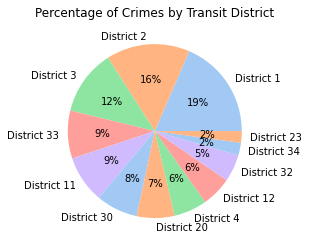

In [1463]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
data = district_counts['Crimes']
labels = district_counts['Transit_District'].apply(lambda x: 'District ' + str(x))

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Percentage of Crimes by Transit District')
plt.savefig("TransitDistrict_pct.png")
plt.show()



In [1485]:
#crimes_merged1.groupby(['Transit_district_x'])[['Transit_district_x','Station','Crimes']].head().reset_index()
district_plot_df = crimes_merged1[['Transit_district_x','Crimes']]
district_plot_df.groupby(['Transit_district_x'])['Crimes'].sum()
#crimes_merged1.groupby(['Transit_district_x','Crimes']).sum()
#crimes_merged1.groupby([['Transit_district_x']])['Crimes'].sum()

Transit_district_x
1     198
2     166
3     130
4      66
11     94
12     60
20     75
23     23
30     83
32     54
33     95
34     25
Name: Crimes, dtype: int64

In [1499]:
df_crime.columns

Index(['Complaint_number', 'Complaint_date', 'Complaint_time', 'Precinct',
       'Borough', 'Station', 'Transit_district', 'Geocode', 'Latitude',
       'Longitude'],
      dtype='object')

In [335]:
# Daily crimes by Station

crime_t = df_crime.groupby(['Complaint_date','Station'])[['Complaint_number']].count().reset_index()

crime_t = crime_t.rename({'Complaint_number':'Crimes'}, axis=1)

crime_t.sort_values('Crimes',ascending=False)

,Complaint_date,Station,Crimes
680,2021-05-05,42 ST.-PORT AUTHORITY BUS TERM,4
103,2021-04-02,42 ST.-PORT AUTHORITY BUS TERM,4
282,2021-04-13,FAR ROCKAWAY-MOTT AVE.,4
1456,2021-06-15,42 ST.-PORT AUTHORITY BUS TERM,4
1184,2021-05-31,125 STREET,4
...,...,...,...
597,2021-04-30,207 STREET,1
596,2021-04-30,179 ST.-JAMAICA,1
594,2021-04-30,135 STREET,1
593,2021-04-30,125 STREET,1


Text(0.5, 1.0, 'Complaints over time 42 ST.-PORT AUTHORITY BUS TERM')

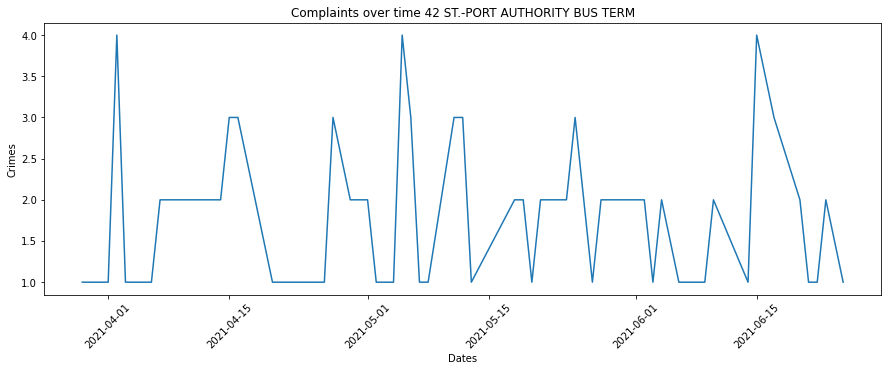

In [337]:

# Isolate crimes for single station 42 ST PORT AUTHORITY over time
daily42 = crime_t[crime_t['Station']=='42 ST.-PORT AUTHORITY BUS TERM']

# Plot

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(daily42['Complaint_date'], daily42['Crimes'])
plt.ylabel('Crimes')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.title('Complaints over time 42 ST.-PORT AUTHORITY BUS TERM')


In [ ]:
# Isolate crimes for single station 34 ST-PENN STATION over time
crime_daily_34STPENN = crime_t[crime_t['Station']=='34 ST.-PENN STATION']
crime_daily_34STPENN.head()


Text(0.5, 1.0, 'Complaints over time for 34 ST - PENN Station')

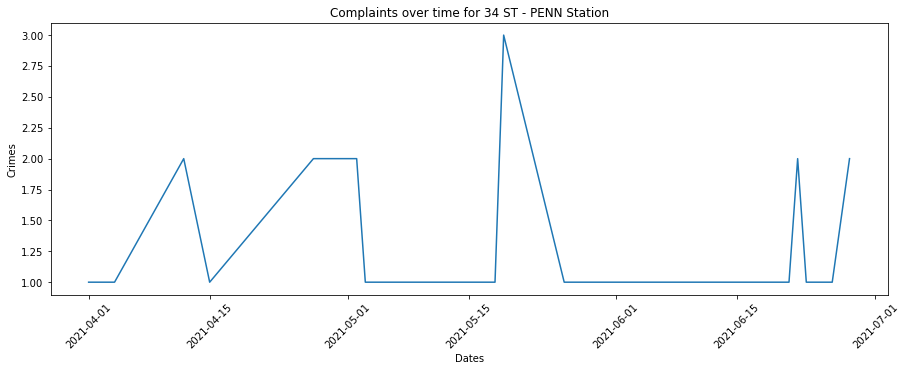

In [1551]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(crime_daily_34STPENN['Complaint_date'], crime_daily_34STPENN['Crimes'])
plt.ylabel('Crimes')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.title('Complaints over time for 34 ST - PENN Station')


In [341]:
# Daily crimes by District

crime_by_d = df_crime.groupby(['Complaint_date','Transit_district'])[['Complaint_number']].count().reset_index()

crime_by_d = crime_by_d.rename({'Complaint_number':'Crimes'}, axis=1)
#crime_t['Transit_district'] = crime_t['Transit_district'].astype('int')
crime_by_d.sort_values('Crimes',ascending=False)

,Complaint_date,Transit_district,Crimes
46,2021-04-02,1.0,11
191,2021-04-19,4.0,9
733,2021-06-17,30.0,9
153,2021-04-15,1.0,9
714,2021-06-15,4.0,8
...,...,...,...
386,2021-05-10,34.0,1
99,2021-04-07,33.0,1
576,2021-05-31,1.0,1
575,2021-05-30,34.0,1


In [338]:

d1_precincts = df_crime[df_crime['Transit_district']==1.0]['Precinct'].unique()
d1_precincts

array([20, 14, 18, 19, 10, 24])

In [1553]:

d2_precincts = df_crime[df_crime['Transit_district']==2.0]['Precinct'].unique()
d2_precincts

array([ 1, 10, 13, 14,  6,  5])

In [342]:
# Isolate District 1 (which includes PABT and TIMES SQ)

crime_daily_DIST1 = crime_by_d[crime_by_d['Transit_district']==1.0]
crime_daily_DIST1.head()



,Complaint_date,Transit_district,Crimes
0,2021-03-28,1.0,2
9,2021-03-29,1.0,4
19,2021-03-30,1.0,1
28,2021-03-31,1.0,3
37,2021-04-01,1.0,4


Text(0.5, 1.0, 'District 1 Crimes: Precincts 20, 14, 18, 19, 10 and 24')

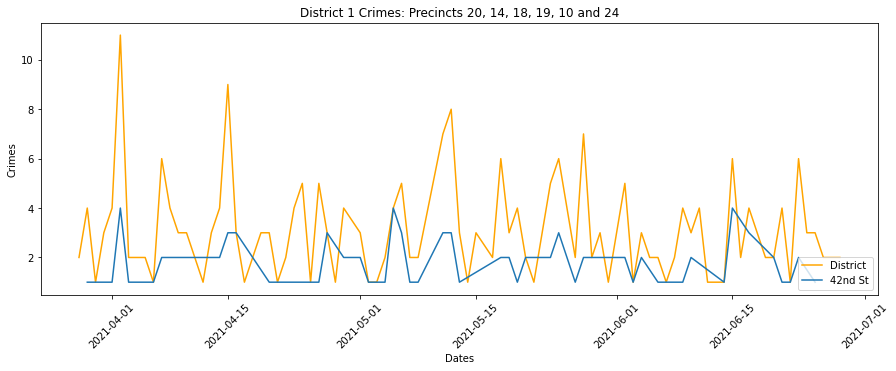

In [352]:
# PLOT district 1  crime totals
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(crime_daily_DIST1['Complaint_date'], crime_daily_DIST1['Crimes'], color='orange')
plt.plot(daily42['Complaint_date'], daily42['Crimes'])
plt.legend(["District", "42nd St"], loc ="lower right")
plt.ylabel('Crimes')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.title('District 1 Crimes: Precincts 20, 14, 18, 19, 10 and 24' )

In [343]:
# Isolate District 2 (which includes 34 ST Penn Station)

crime_daily_DIST2 = crime_by_d[crime_by_d['Transit_district']==2.0]
crime_daily_DIST2.head()
# plot 
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(crime_daily_DIST2['Complaint_date'], crime_daily_DIST2['Crimes'])
plt.ylabel('Crimes')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.title('District 2 Crimes: Precincts 1, 10, 13, 14,  6, and 5' )

,Complaint_date,Transit_district,Crimes
1,2021-03-28,2.0,2
10,2021-03-29,2.0,5
20,2021-03-30,2.0,2
29,2021-03-31,2.0,2
38,2021-04-01,2.0,2


Text(0.5, 1.0, 'District 2 Crimes: Precincts 1, 10, 13, 14,  6, and 5')

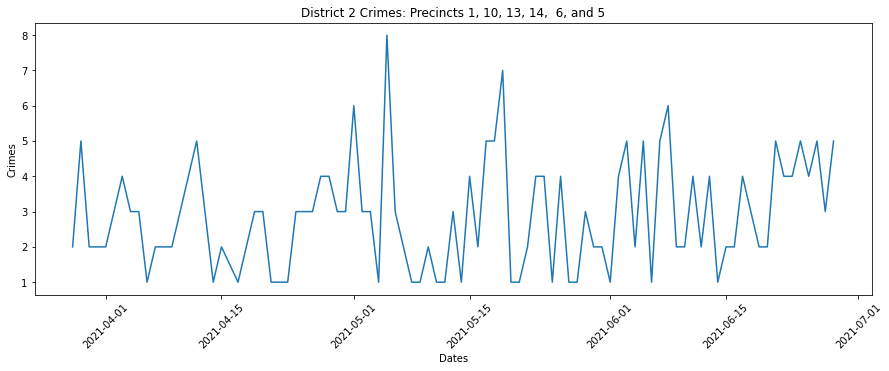

In [1554]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(crime_daily_DIST2['Complaint_date'], crime_daily_DIST2['Crimes'])
plt.ylabel('Crimes')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.title('District 2 Crimes: Precincts 1, 10, 13, 14,  6, and 5' )


,Complaint_date,Station,Crimes
2,2021-03-28,34 ST.-HERALD SQ.,1
15,2021-03-29,34 ST.-HERALD SQ.,1
80,2021-04-01,34 ST.-PENN STATION,1
102,2021-04-02,34 ST.-HERALD SQ.,1
116,2021-04-02,WEST 34 STREET/HUDSON YARDS,1
139,2021-04-04,34 ST.-PENN STATION,1
153,2021-04-05,34 ST.-HERALD SQ.,1
165,2021-04-05,WEST 34 STREET/HUDSON YARDS,1
170,2021-04-06,34 ST.-HERALD SQ.,1
243,2021-04-11,34 ST.-HERALD SQ.,1


In [ ]:
crime_daily_34PENN = crime_t[crime_t['Station']=='42 ST.-PORT AUTHORITY BUS TERM']
crime_daily_42ST.head()

In [1519]:
import altair as alt
import numpy as np
import pandas as pd

source = crime_daily_42ST

#plt.plot(single_turnstile['DATE'], single_turnstile['DAILY_ENTRIES'])

alt.Chart(source).mark_line().encode(
    x='Complaint_date',
    #x=alt.X('Complaint_date:O', title='Complaint_date'),
    y='Crimes'
)

alt.Chart(...)

In [1497]:
#df_crime.groupby(['Station']).head()
# plot busiest Stations
source = df_crime.sort_values('Complaint_number',ascending = False).head(10)

alt.Chart(source, title="most crimes").mark_bar().encode(
    #x='NAME:O',
    x=alt.X('Station:O', title='Station Name'),
    #y="DAILY_ENTRIES:Q",
    y=alt.Y('Complaint_number:Q', title='Crimes'),
    # The highlight will be set on the result of a conditional statement
    color=alt.condition(
        alt.datum.UPPER_NAME == '86 ST',  # If UPPER_NAME is 86 ST this test returns True,
        
        alt.value('orange'),     # which sets the bar orange.
        alt.value('steelblue')   # And if it's not true it sets the bar steelblue.
    )
).properties(width=600)

alt.Chart(...)

In [1486]:
df_crime.head()

,Complaint_number,Complaint_date,Complaint_time,Precinct,Borough,Station,Transit_district,Geocode,Latitude,Longitude
181,105431546,2021-03-29,2021-10-12 05:35:00,7,MANHATTAN,DELANCEY STREET,4.0,POINT (-73.98820145399996 40.718564066000056),40.718564,-73.988201
526,980993383,2021-03-30,2021-10-12 23:18:00,71,BROOKLYN,PARKSIDE AVENUE,32.0,POINT (-73.96190341499994 40.654879667000046),40.654880,-73.961903
926,577579144,2021-03-29,2021-10-12 15:00:00,43,BRONX,CASTLE HILL AVENUE,12.0,POINT (-73.85168677499998 40.83420938300002),40.834209,-73.851687
987,384561006,2021-03-29,2021-10-12 14:00:00,44,BRONX,161 ST.-YANKEE STADIUM,11.0,POINT (-73.92593075599996 40.827819901000055),40.827820,-73.925931
1450,962954674,2021-03-30,2021-10-12 20:28:00,1,MANHATTAN,BROAD STREET,2.0,POINT (-74.01118971799998 40.70628680300007),40.706287,-74.011190


In [976]:
# read in df_stations for fresh start
stations = pd.read_csv('data/df_stations.csv')
# Clean up STATION names to prepare for merge crime_totals with station_totals


In [977]:
#df_stations[df_stations.UPPER_NAME.str.contains('PORT AUTHORITY BUS TERM')]
stations[stations.UPPER_NAME.str.contains('HERALD')]

,Unnamed: 0,URL,OBJECTID,NAME,the_geom,LINE,NOTES,Latitude,Longitude,UPPER_NAME
144,144,http://web.mta.info/nyct/service/,145,Herald Sq - 34th St,POINT (-73.9879368338264 40.74964456009442),N-Q-R-W,"N,Q-all times, R-all times exc nights",40.749645,-73.987937,34 ST-HERALD SQ
365,365,http://web.mta.info/nyct/service/,366,Herald Sq - 34th St,POINT (-73.98777189072918 40.74978939990011),B-D-F-M,"B,M-weekdays and evenings, D,F-all times",40.749789,-73.987772,34 ST-HERALD SQ


In [ ]:
LINCOLN CENTER-66 ST
LINCOLN CTR-66 ST

In [954]:
# copy for manipulation
ct = crime_totals.copy()
#81 ST.-MUSEUM OF NATURAL HISTO

In [955]:
#ct[ct.Station.str.contains('PORT')]
ct[ct.Station.str.contains('HERALD')]

,Transit_district,Station,Crimes
21,2,34 ST.-HERALD SQ.,18


In [956]:

def name_swap3(oldstr):
    try:
        split_ = oldstr.split('.-')
        newstr = split_[1] + '-' + split_[0]
        return newstr.strip()
    except:
        return oldstr
#name_swap3('34 ST.-PENN STATION')
#ct.Station = ct.Station.apply(name_swap)
#ct.head(20)

In [957]:
ct.Station = ct.Station.apply(name_swap3)

#special cases
#ct.Station = ct.Station.str.replace('42 ST.-PORT AUTHORITY BUS TERM','PORT AUTHORITY BUS TERM-42 ST')
ct.Station = ct.Station.str.replace('47-50 STS./ROCKEFELLER CTR.','ROCKEFELLER CTR-47-50 STS')
ct.Station = ct.Station.str.replace('CATHEDRAL PKWY.-110 ST','CATHEDRAL PKWY (110 ST)')
ct.Station = ct.Station.str.replace('PENN STATION-34 ST','34 ST-PENN STA')
ct.Station = ct.Station.str.replace('34 ST.-HERALD SQ.','34 ST-HERALD SQ')

# fixing station from crime_totals

ct.Station = ct.Station.str.replace('CENTER','CTR')
ct.Station = ct.Station.str.replace('STREET','ST')
ct.Station = ct.Station.str.replace('AVENUE','AVE')
ct.Station = ct.Station.str.replace('BLVD.','BLVD')

#ct.Station = ct.Station.str.replace('SQUARE','SQ')
ct.sort_values('Crimes',ascending=False).head(20)

,Transit_district,Station,Crimes
0,1,PORT AUTHORITY BUS TERM-42 ST,98
1,1,TIMES SQUARE-42 ST,44
8,1,COLUMBUS CIRCLE-59 ST,40
74,4,125 ST,39
22,2,34 ST-PENN STA,32
273,32,CROWN HEIGHTS-UTICA AVE,29
50,3,125 ST,28
42,2,W. 4 ST,27
81,4,GRAND CENTRAL-42 ST,26
30,2,CANAL ST,23


In [948]:
#AFTER
#ct[ct.Station.str.contains('PORT')]
ct[ct.Station.str.contains('CTR')]

,Transit_district,Station,Crimes
3,1,ROCKEFELLER CTR-47-50 STS,5
9,1,LINCOLN CTR-66 ST,4
190,20,PARSONS/ARCHER-JAMAICA CTR,10


In [958]:

#test merge
ct1 = ct.copy()
ds1 = stations.copy()
crimes_merged = pd.merge(
  ct1, 
  ds1, 
  left_on=['Station'], 
  right_on=['UPPER_NAME']
)
crimes_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 0 to 343
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transit_district  344 non-null    int64  
 1   Station           344 non-null    object 
 2   Crimes            344 non-null    int64  
 3   Unnamed: 0        344 non-null    int64  
 4   URL               344 non-null    object 
 5   OBJECTID          344 non-null    int64  
 6   NAME              344 non-null    object 
 7   the_geom          344 non-null    object 
 8   LINE              344 non-null    object 
 9   NOTES             344 non-null    object 
 10  Latitude          344 non-null    float64
 11  Longitude         344 non-null    float64
 12  UPPER_NAME        344 non-null    object 
dtypes: float64(2), int64(4), object(7)
memory usage: 37.6+ KB


In [970]:

crimes_merged1 = crimes_merged[['Transit_district', 'Station', 'Crimes', 
'NAME', 'the_geom', 'Latitude',
       'Longitude', 'UPPER_NAME']]
crimes_merged1 = crimes_merged1.drop_duplicates(subset='UPPER_NAME', keep="first")
crimes_merged1.sort_values('Crimes',ascending=False).head(20)

,Transit_district,Station,Crimes,NAME,the_geom,Latitude,Longitude,UPPER_NAME
0,1,PORT AUTHORITY BUS TERM-42 ST,98,42nd St - Port Authority Bus Term,POINT (-73.98973500085859 40.757307998551504),40.757308,-73.989735,PORT AUTHORITY BUS TERM-42 ST
11,1,COLUMBUS CIRCLE-59 ST,40,59th St - Columbus Circle,POINT (-73.98192900232715 40.76824700063689),40.768247,-73.981929,COLUMBUS CIRCLE-59 ST
62,2,34 ST-PENN STA,32,34th St - Penn Station,POINT (-73.99105699913983 40.75037300003949),40.750373,-73.991057,34 ST-PENN STA
114,3,125 ST,28,125th St,POINT (-73.94549500011411 40.807753999182815),40.807754,-73.945495,125 ST
71,2,CANAL ST,23,Canal St,POINT (-74.00019299927328 40.71880300107709),40.718803,-74.000193,CANAL ST
39,2,14 ST,21,14th St,POINT (-74.00020100063497 40.737825999728116),40.737826,-74.000201,14 ST
83,2,FULTON ST,19,Fulton St,POINT (-73.97537499833149 40.68711899950771),40.687119,-73.975375,FULTON ST
172,11,YANKEE STADIUM-161 ST,18,161st St - Yankee Stadium,POINT (-73.92569199505733 40.82823032742169),40.828230,-73.925692,YANKEE STADIUM-161 ST
122,3,135 ST,18,135th St,POINT (-73.94077000106708 40.8142290003391),40.814229,-73.940770,135 ST
138,3,96 ST,17,96th St,POINT (-73.9510700015425 40.78567199998607),40.785672,-73.951070,96 ST


In [95]:
## begin clean up of Station column
crime_totals['Station'] = crime_totals['Station'].str.replace('ZEREGA AVENUE','ZEREGA AV')
crime_totals['Station'] = crime_totals['Station'].str.replace('103 ST-CORONA PLAZA','103 ST-CORONA')
crime_totals['Station'] = crime_totals['Station'].str.replace('138 ST-GRAND CONCOURSE','138/GRAND CONC')
crime_totals['Station'] = crime_totals['Station'].str.replace('21 ST-QUEENSBRIDGE','21 ST-QNSBRIDGE')
crime_totals['Station'] = crime_totals['Station'].str.replace('AVENUE','AV')
crime_totals['Station'] = crime_totals['Station'].str.replace('STREET','ST')
crime_totals['Station'] = crime_totals['Station'].str.replace('SUTPHIN BLVD.-ARCHER AVE.','SUTPHIN BLVD')
crime_totals['Station'] = crime_totals['Station'].str.replace('BEDFORD PK. BLVD.','BEDFORD PK BLVD')
crime_totals['Station'] = crime_totals['Station'].str.replace('CONCOURSE','CONC')
crime_totals['Station'] = crime_totals['Station'].str.replace('BLVD.','BLVD')
crime_totals['Station'] = crime_totals['Station'].str.replace('PK.','PK')
## begin clean up of STATION column

#station_totals['STATION'] = station_totals['STATION'].str.replace('STREET','ST')
#station_totals['STATION'] = station_totals['STATION'].str.replace('163 ST-AMSTERDM','163 ST-AMSTERDAM AVE.')
#station_totals['STATION'] = station_totals['STATION'].str.replace('161/YANKEE STAD','161 ST-YANKEE STADIUM')
#station_totals['STATION'] = station_totals['STATION'].str.replace('GRAND-NEWTOWN','GRAND AVE.-NEWTON')
#station_totals['STATION'] = station_totals['STATION'].str.replace('/GRAND ','GRAND ')

In [ ]:
# merge crime_totals with station_totals

inner_merged = pd.merge(
  station_totals, 
  crime_daily, 
  left_on=['STATION'], 
  right_on=['Station']
)
inner_merged.head()

#new_df = pd.merge(A_df, B_df,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])

## VISUALIZATIONS

In [73]:
import altair as alt
from vega_datasets import data

source = station_totals.head(10)

alt.Chart(source,title="TOP 10 BUSIEST STATIONS").mark_bar().encode(
    x='DAILY_ENTRIES:Q',
    y=alt.Y('STATION:N', sort='-x'),
    color = alt.Color('STATION', legend=None)
)

alt.Chart(...)